# Análise e treinamento do modelo

A Diabetes é uma doença que afetar todas escalas da sociendade, seja Brasileira ou mundial, e com pandemia da Covid-19 tivemos esse problema agravado.

"A Federação Internacional de Diabetes alerta para o aumento de 16% de incidência da doença na população mundial nos últimos dois anos, entre 2019 e 2021. Neste domingo (14), é celebrado o dia de conscientização global contra uma das doenças que mais mata no Brasil – foram 214 mil mortes de pessoas entre 20 e 79 anos neste ano – , com foco na diabete mellitus."(CNN BRASIL, 2021)

Neste trabalho tivemos a ideia de construir um modelo para prever se uma pessoa tem diabetes ou não por meio dos dados fornecido pelo proprio paciente,ou seja, o paciente acessa um site, preencha um formulario e no final descubre se possue ou não ter a doença. Para treinar o modelo utilizamos um banco de dados gerado atravez de pesquisa realizada pela Behavioral Risk Factor Surveillance System (BRFSS) em 2015.

banco de dados: https://www.kaggle.com/alexteboul/diabetes-health-indicators-dataset?select=diabetes_binary_5050split_health_indicators_BRFSS2015.csv
fonte: https://www.cnnbrasil.com.br/saude/diabetes-aumentou-16-na-populacao-mundial-nos-ultimos-dois-anos/

## Explorando os dados

In [0]:
# Importando bibliotecas para analise do dados
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
# Baixando os dados e carregando no pandas
!wget -b 'https://raw.githubusercontent.com/DanielGGuerra/Predict-patients-with-diabetes/main/diabetes_binary_5050split_health_indicators_BRFSS2015.csv'

df_diabetes = spark.read.csv(
  path='file:///databricks/driver/diabetes_binary_5050split_health_indicators_BRFSS2015.csv',
  inferSchema=True,
  header=True
).toPandas()

Continuing in background, pid 2828.
Output will be written to ‘wget-log.5’.


Primeiro busquei entender quais seriam as variveis correlacionadas e imaginar o motivo. Longo criei a matriz de confursão abaixo para analisamos.

Observe que a variavel GenHlth possuir correlação "média" com DiffWalk, PhysHlth, MentHlth e que Income e Education também possui correlações "média".

Em resumo significado de cada variável:

<p>GenHlth: Nivel de saúde geral.</p>
<p>PhysHlth: Doença fisica ou lesão.</p>
<p>DiffWalk: Dificuldade para caminhar.</p>
<p>MentHlth: Nivel da saúde mental.</p>
<p>Income: Classificão da renda.</p>
<p>Education: Classificão da escolaridade.</p>

Out[30]: <AxesSubplot:>

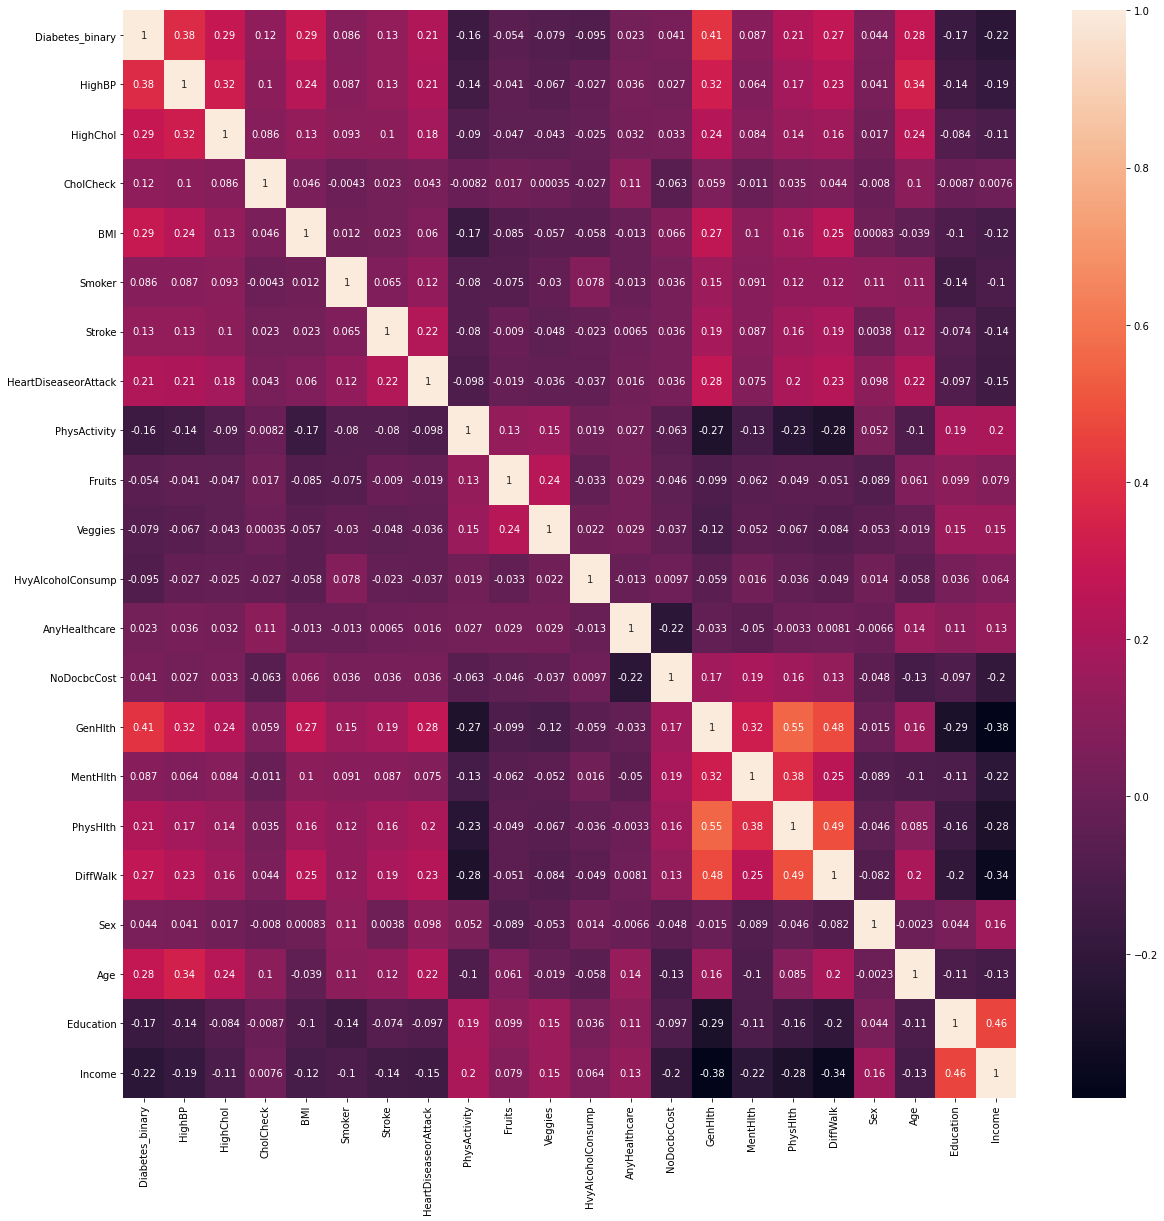

In [0]:
corr = df_diabetes.corr()
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr, annot=True)

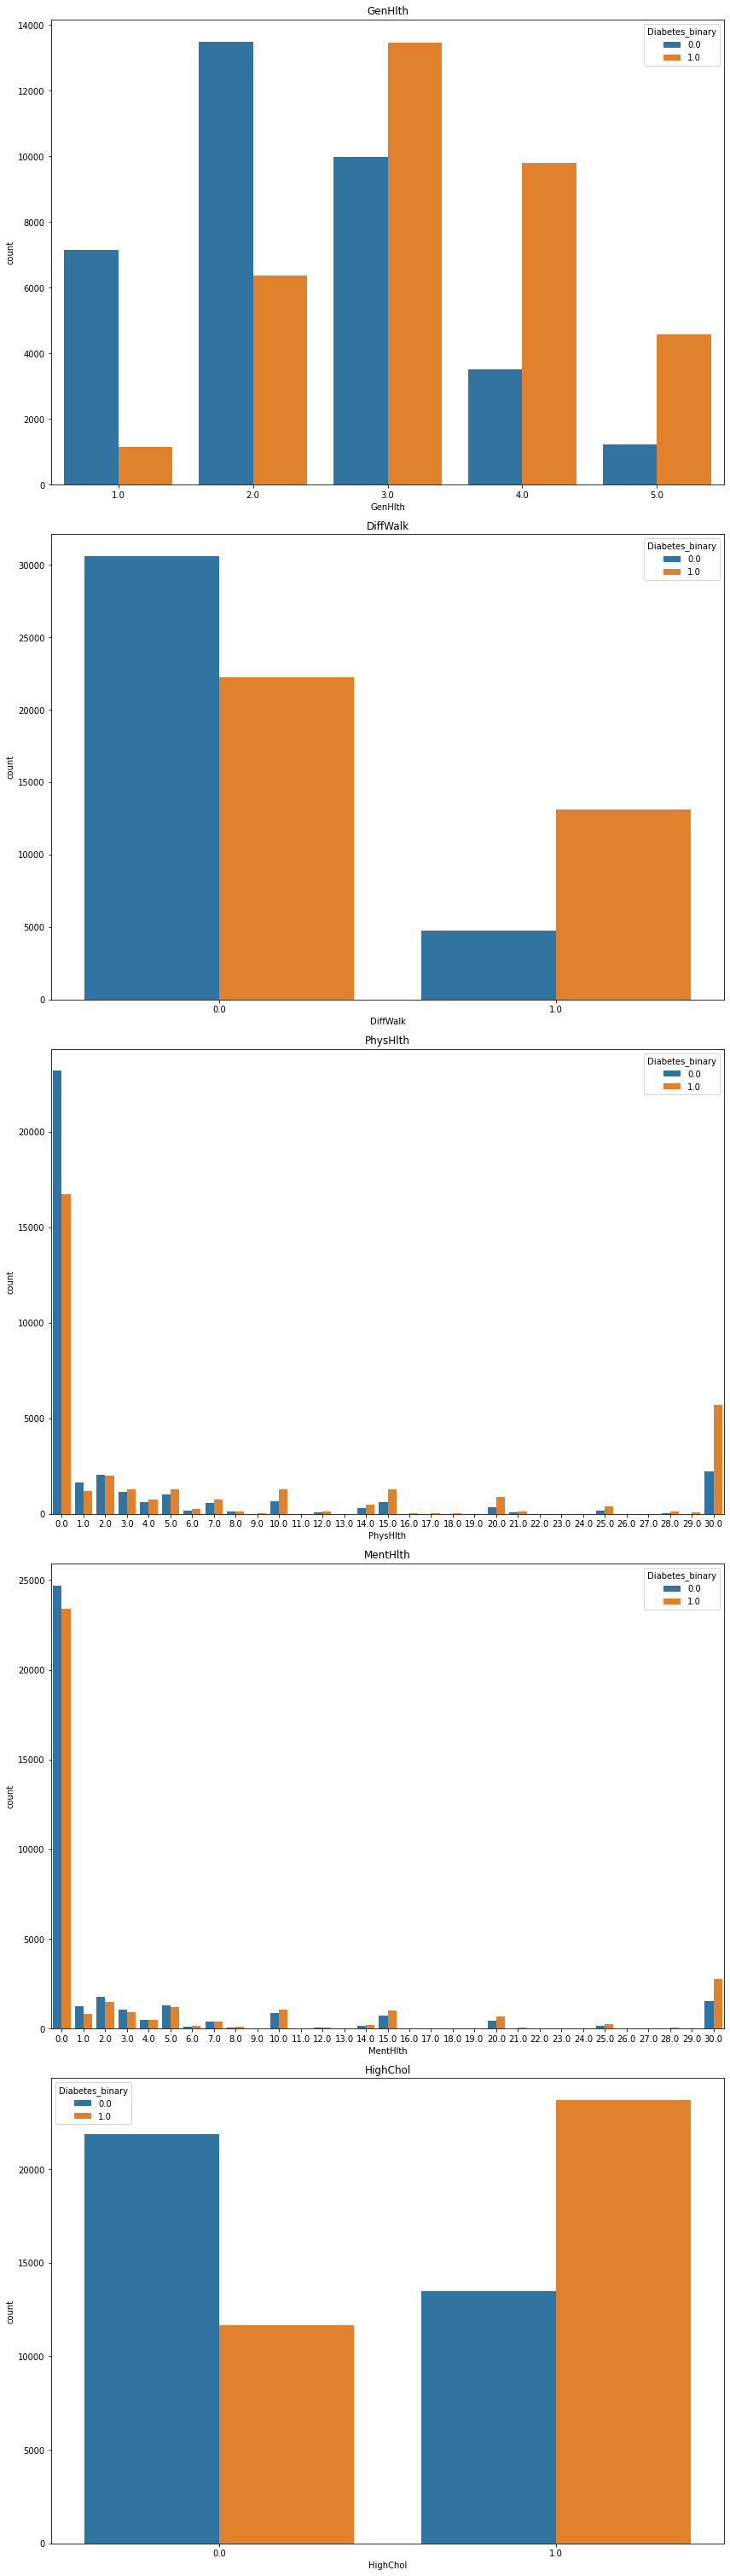

In [0]:
col = ['GenHlth', 'DiffWalk', 'PhysHlth', 'MentHlth','HighChol']

plt.figure(figsize=(12, 50))
for i in range(len(col)):
  plt.subplot(len(col)+1, 1, i + 1)
  ax = sns.countplot(x=col[i], hue='Diabetes_binary', data=df_diabetes)
  ax.set_title(col[i])
plt.tight_layout();

Out[95]: <matplotlib.legend.Legend at 0x7f3e329691f0>

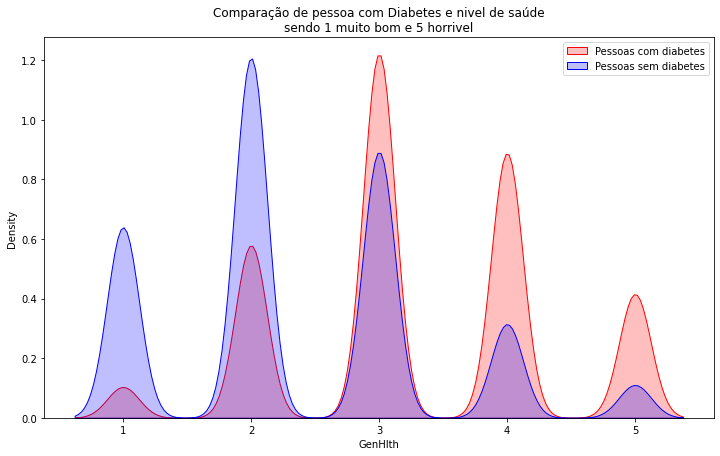

In [0]:
# KDE (Kernel Density Estimate)
plt.figure(figsize=(12,7))
sns.kdeplot(
  df_diabetes.query('Diabetes_binary==1')['GenHlth'],
  label = 'Pessoas com diabetes', 
  shade = True, 
  color='r')

sns.kdeplot(
  df_diabetes.query('Diabetes_binary==0')['GenHlth'],
  label = 'Pessoas sem diabetes', 
  shade = True, 
  color='b')

plt.title('Comparação de pessoa com Diabetes e nivel de saúde\nsendo 1 muito bom e 5 horrivel')
plt.legend()

# Modelo de predição de diabetes

### Normalização dos dados

In [0]:
#Separando as variaveis numericas das categoricas.
X_var_categoricas = df_diabetes[
  ['HighBP',
  'HighChol',
  'CholCheck',
  'Smoker',
  'Stroke',
  'HeartDiseaseorAttack',
  'PhysActivity',
  'Fruits',
  'Veggies',
  'HvyAlcoholConsump',
  'AnyHealthcare',
  'NoDocbcCost',
  'GenHlth',
  'DiffWalk',
  'Sex',
  'Education',
  'Income']
]


X_var_numericos = df_diabetes[
  ['BMI',
  'MentHlth',
  'PhysHlth',
  'Age']
]


In [0]:
from sklearn.preprocessing import OneHotEncoder

oneHotEncoder = OneHotEncoder()
X_var_categoricas = pd.DataFrame(
  oneHotEncoder.fit_transform(X_var_categoricas).toarray()
)

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X = pd.concat([X_var_numericos, X_var_categoricas], axis=1)

scaler = MinMaxScaler()

X = scaler.fit_transform(X)
y = df_diabetes['Diabetes_binary']

## Treinamento do modelo

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

### Modelo Regressão Logistica

In [0]:
from sklearn.linear_model import LogisticRegression

model_logistic = LogisticRegression()
model_logistic.fit(X_train, y_train)

/databricks/python/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Out[177]: LogisticRegression()

## Avaliação do modelo: Matriz de confusão e Curva ROC

In [0]:
!pip install yellowbrick

You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.


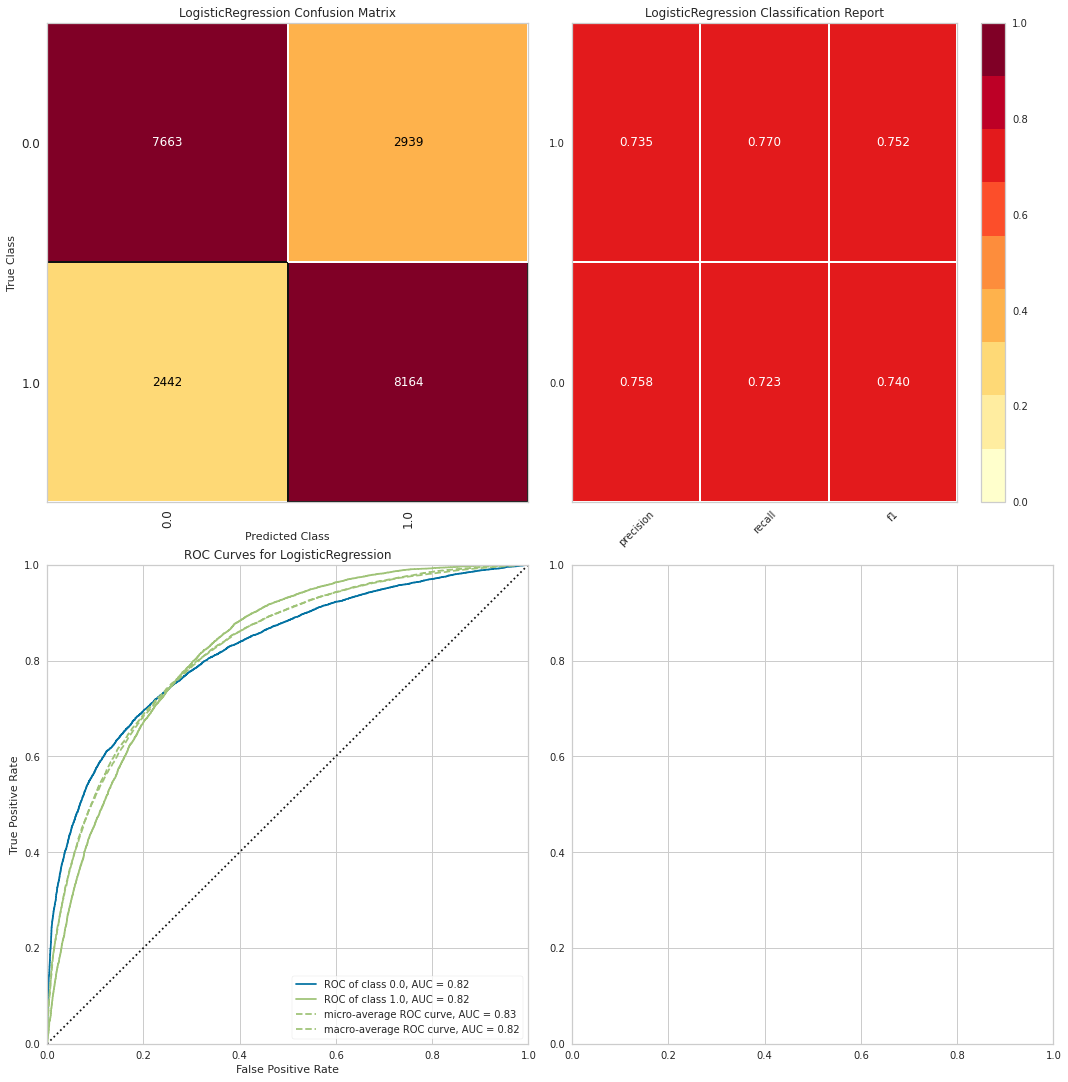

In [0]:
from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC

fig, axes = plt.subplots(2,2,figsize=(15,15))

visualgrid = [
    ConfusionMatrix(model_logistic, ax=axes[0][0]),
    ClassificationReport(model_logistic, ax=axes[0][1]),
    ROCAUC(model_logistic, ax=axes[1][0]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()

plt.show()